### Importing data from google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Installing catboot and importing libraries 

In [3]:
!pip install catboost

In [4]:
import pandas as pd
import numpy as np
import csv
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


from wordcloud import WordCloud
from tqdm import tqdm

import re
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('/content/gdrive/My Drive/dataset/mbti_1.csv')
data.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

In [5]:
data.describe(include='O')

type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'I'm finding the lack of me in these posts ver...
freq    1832                                                  1

In [6]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

### Feature selection


In [7]:
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)
data['words_per_comment'] = data['posts'].apply(lambda x: len(x.split())/50)
data['variance_of_word_counts'] = data['posts'].apply(lambda x: var_row(x))
data['question_per_comment'] = data['posts'].apply(lambda x: x.count('?')/50)
data['excl_per_comment'] = data['posts'].apply(lambda x: x.count('!')/50)
data['ellipsis_per_comment'] = data['posts'].apply(lambda x: x.count('...')/50)

data.head()

type  ... ellipsis_per_comment
0  INFJ  ...                 0.30
1  ENTP  ...                 0.38
2  INTP  ...                 0.26
3  INTJ  ...                 0.52
4  ENTJ  ...                 0.42

[5 rows x 7 columns]

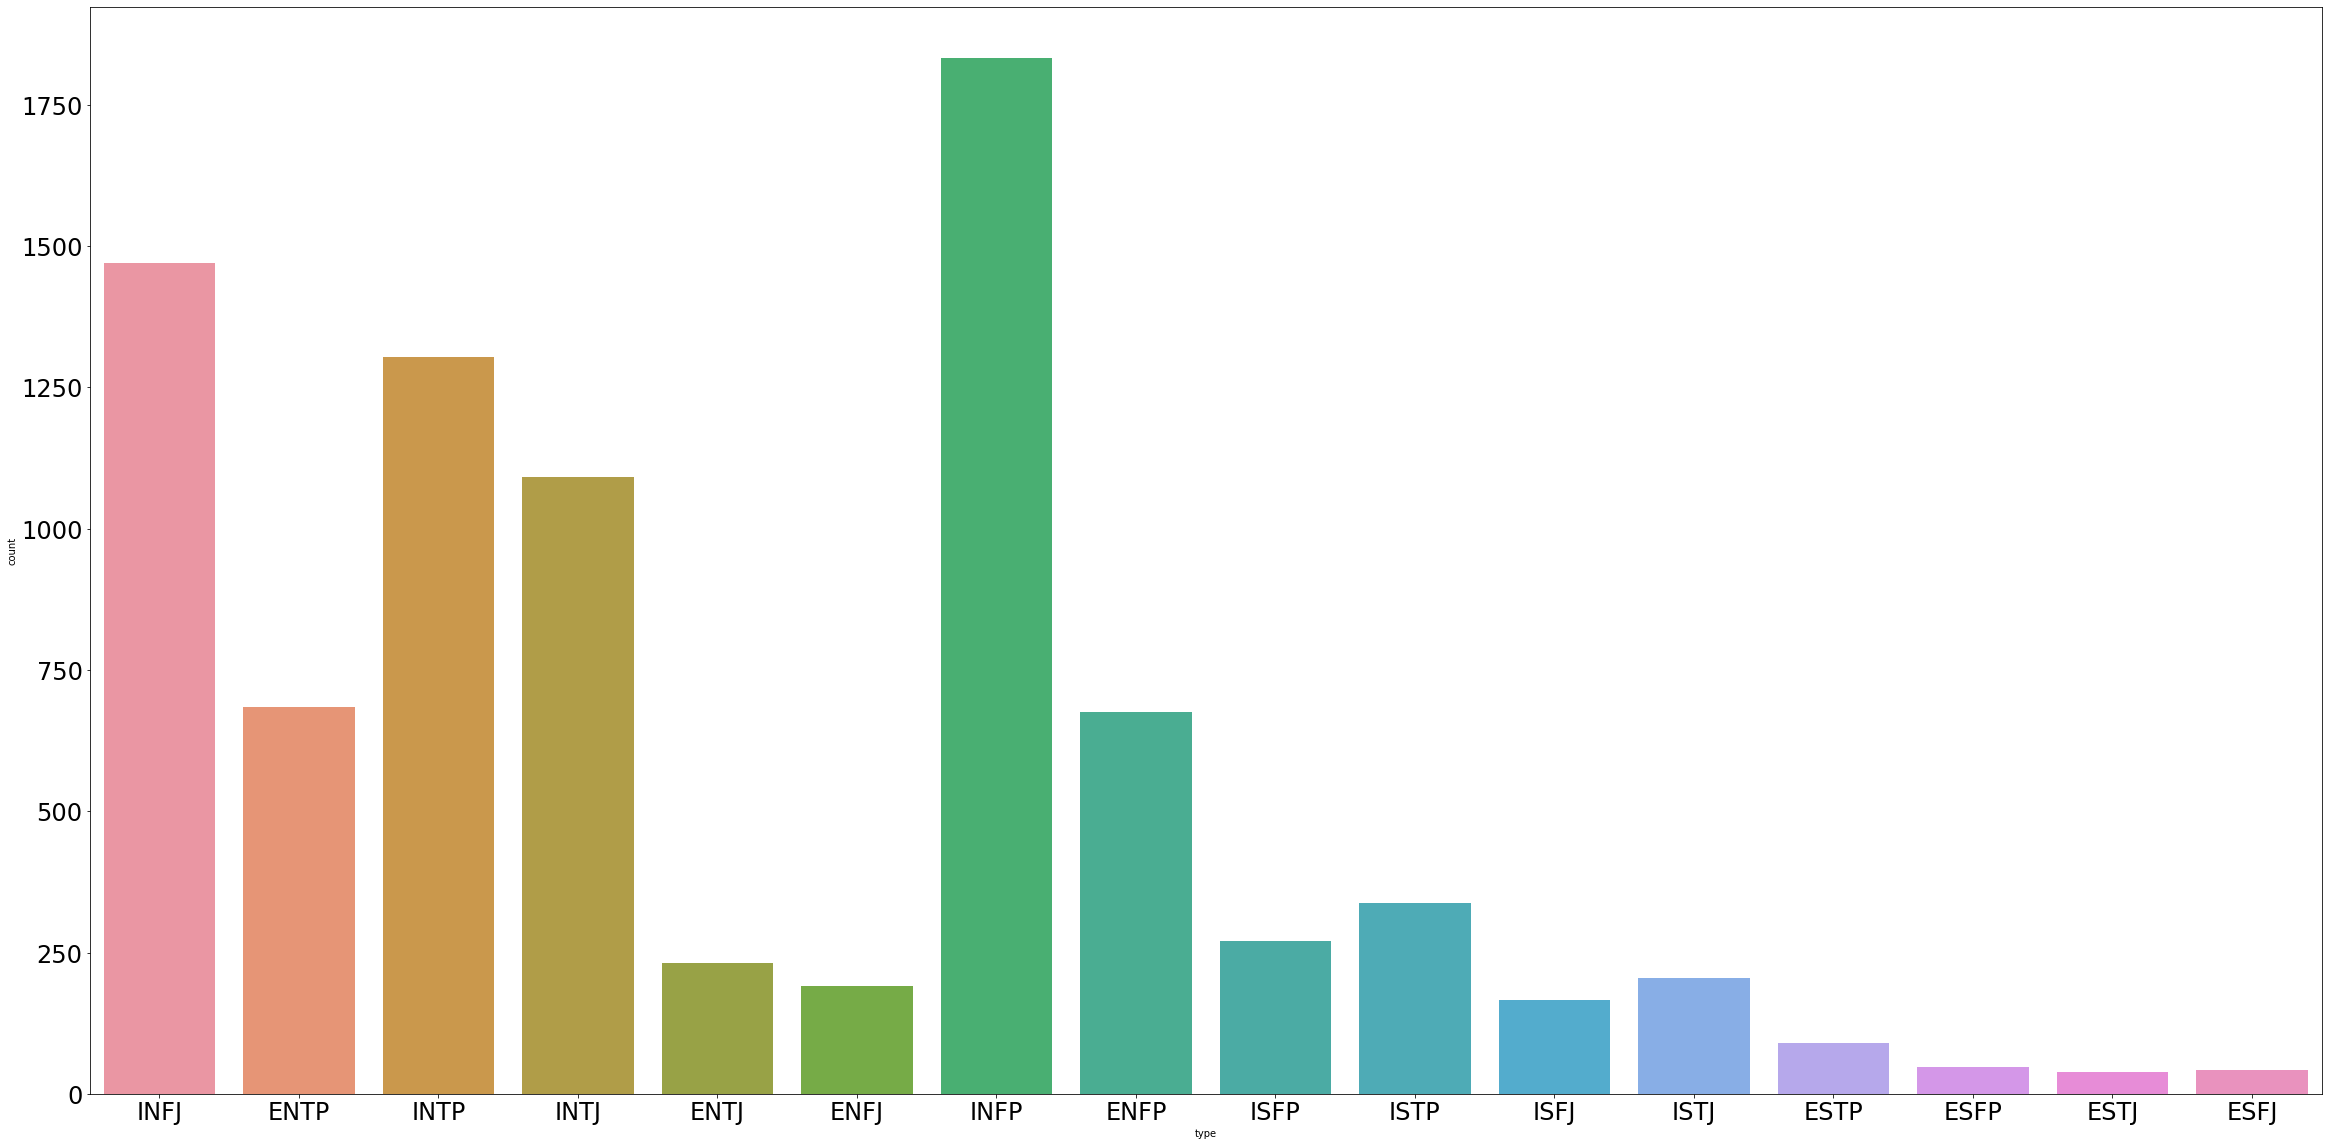

In [8]:
plt.figure(figsize=(40,20))
plt.xticks(fontsize=24, rotation=0)
plt.yticks(fontsize=24, rotation=0)
sns.countplot(data=data, x='type')

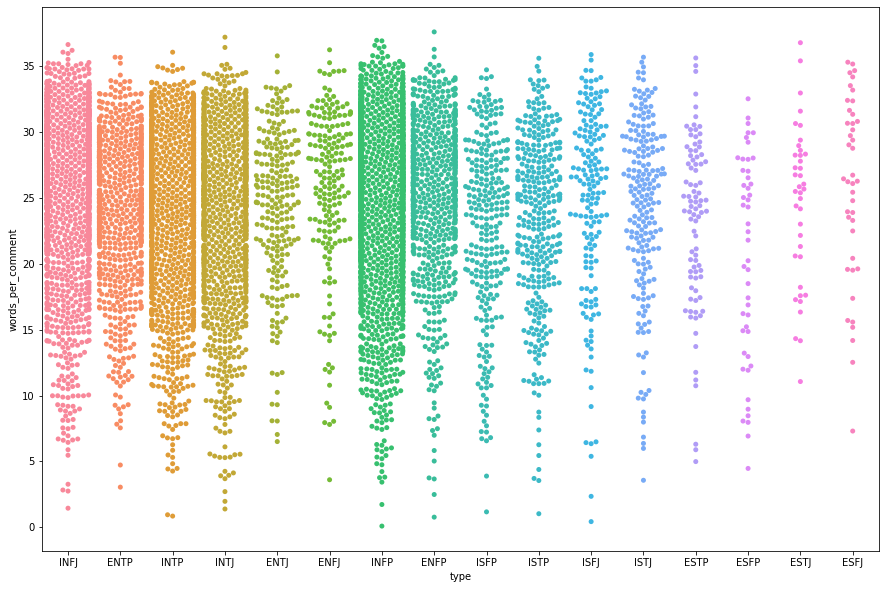

In [9]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "words_per_comment", data=data)

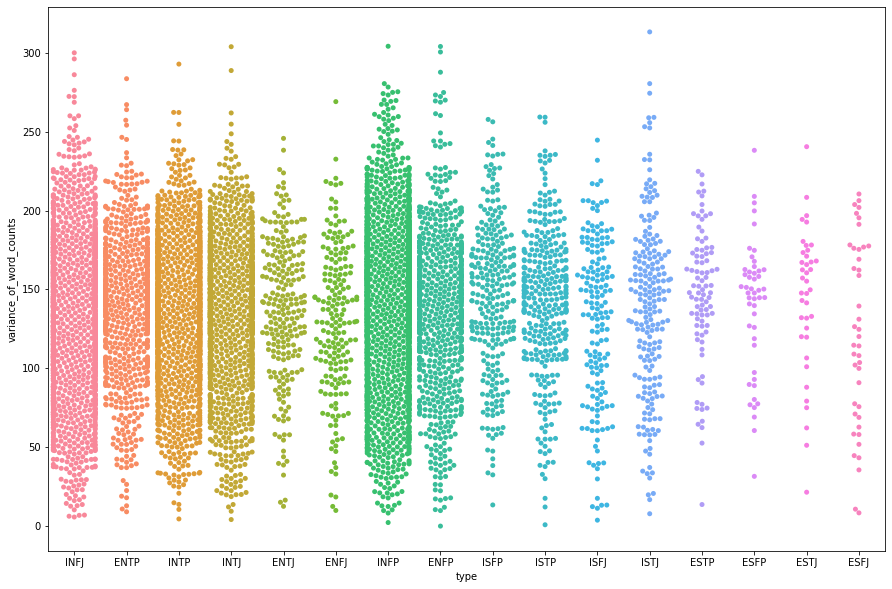

In [10]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "variance_of_word_counts", data=data)

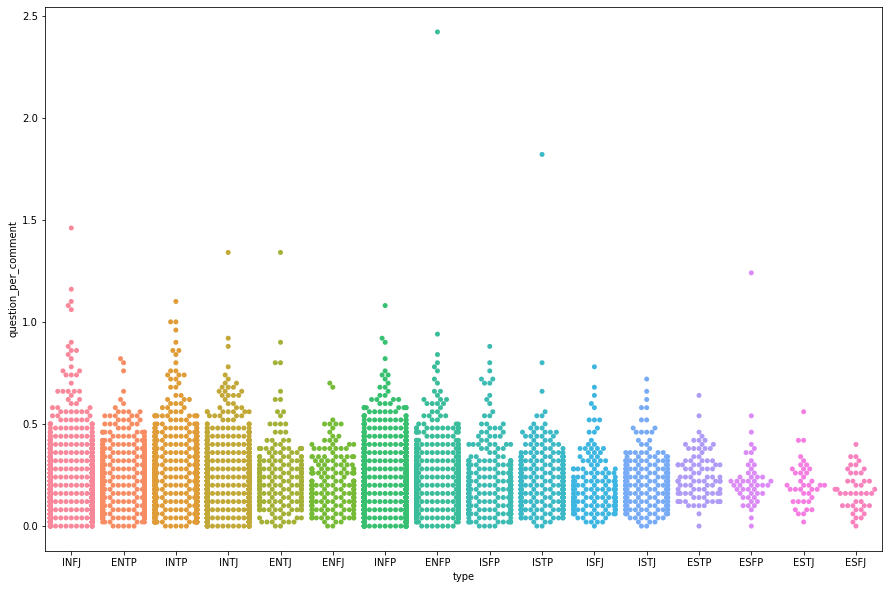

In [11]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "question_per_comment", data=data)

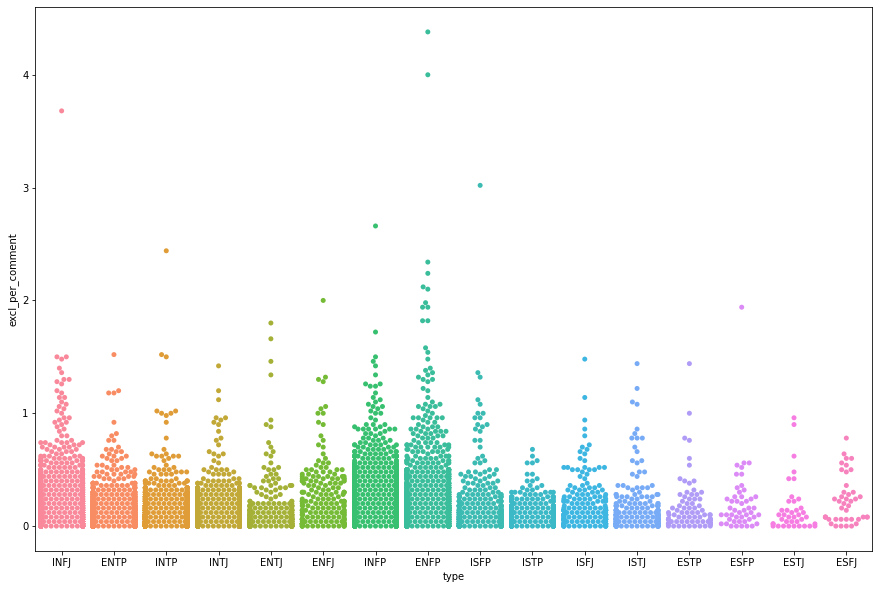

In [12]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "excl_per_comment", data=data)

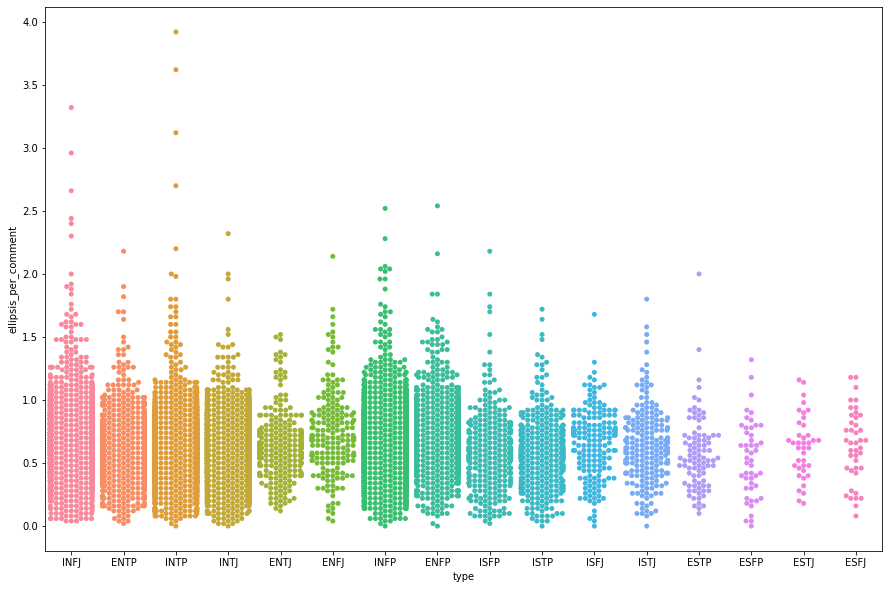

In [13]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "ellipsis_per_comment", data=data)

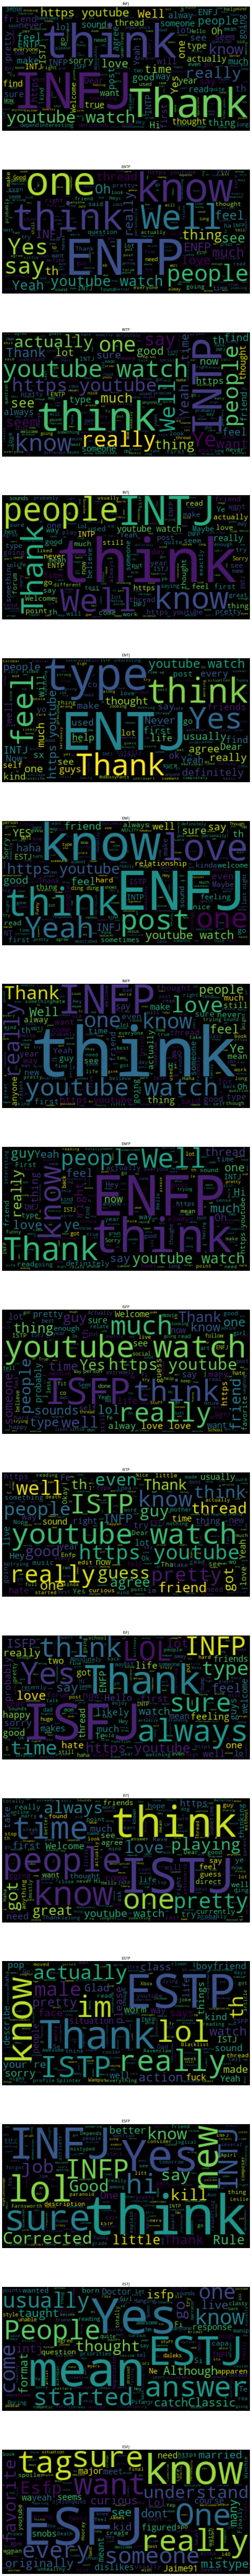

In [14]:
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(len(data['type'].unique()), sharex=True, figsize=(15,10*len(data['type'].unique())))

k = 0
for i in data['type'].unique():
    text_4 = data[data['type'] == i]
    wordcloud = WordCloud().generate(text_4['posts'].to_string())
    ax[k].imshow(wordcloud, interpolation='bilinear')
    ax[k].axis("off")
    ax[k].set_title(i)
    k+=1


### Preprocessing posts

To normalize posts, we will be:

1. Converting all letters to lowercase.
2. Remove '|||'
3. Removing punctuations using regex.
4. Removing URLs, links etc ... using 
5. Convert words to integers

In [15]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)

In [16]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
        # Remove |||
        sentence=sentence.replace('|||',"") 

        # Remove URLs, links etc
        sentence = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', sentence, flags=re.MULTILINE) 

        # Remove puntuations 
        puncs1=['@','#','$','%','^','&','*','(',')','-','_','+','=','{','}','[',']','|','\\','"',"'",';',':','<','>','/']
        for punc in puncs1:
            sentence=sentence.replace(punc,'') 

        puncs2=[',','.','\n']
        for punc in puncs2:
            sentence=sentence.replace(punc,' ')
             
        # Remove extra white spaces
        sentence=re.sub( '\s+', ' ', sentence ).strip()
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [17]:
train_data.posts,train_length=clear_text(train_data)

100%|██████████| 6940/6940 [00:08<00:00, 778.27it/s]


In [18]:
test_data.posts,test_length=clear_text(test_data)

100%|██████████| 1735/1735 [00:22<00:00, 76.90it/s] 


In [19]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

### Tokenizing words

In [20]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [21]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<__main__.Lemmatizer object at 0x7f2d9c92fed0>,
                use_idf=True, vocabulary=None)

In [22]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()
print(train_post)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.03272766 ... 0.         0.         0.        ]
 [0.         0.         0.05374065 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [23]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)
print(train_data.type, train_target[3], train_target[4])

1228    INFP
1290    ISTP
6756    ENFJ
1662    INFP
3338    INFP
        ... 
7292    INFP
1086    INFP
7435    ENTJ
1843    INTP
2530    ENTP
Name: type, Length: 6940, dtype: object 9 9


#Catboost Classifier

In [24]:
train_target.shape

(6940,)

In [25]:
model_cat=CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',verbose=False)
model_cat.fit(train_post,train_target)

In [26]:
print('train classification report \n ',classification_report(train_target,model_cat.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_cat.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.85      0.61      0.71       152
        ENFP       0.78      0.74      0.76       540
        ENTJ       0.89      0.62      0.73       185
        ENTP       0.79      0.77      0.78       548
        ESFJ       0.94      0.44      0.60        34
        ESFP       1.00      0.18      0.31        38
        ESTJ       1.00      0.29      0.45        31
        ESTP       0.97      0.54      0.69        71
        INFJ       0.80      0.83      0.81      1176
        INFP       0.77      0.89      0.83      1465
        INTJ       0.80      0.81      0.80       873
        INTP       0.76      0.86      0.81      1043
        ISFJ       0.93      0.62      0.75       133
        ISFP       0.84      0.65      0.73       217
        ISTJ       0.88      0.69      0.77       164
        ISTP       0.86      0.75      0.80       270

    accuracy                           0.79      

In [27]:
def personality_recomender(text):
    
    return model_cat.predict(text)
    

In [35]:
def convert_to_output(inp):
  inp=vectorizer.transform(inp).toarray()

  target_encoder=LabelEncoder()
  train_target=target_encoder.fit_transform(train_data.type)
  test_target=target_encoder.fit_transform(test_data.type)

  target_names=target_encoder.inverse_transform((personality_recomender(inp)[0]))
  return target_names

In [38]:
def take_input(): 
  user_input=["Hello i am bisht"]
  # const= input("introduce yourself")
  # user_input.append(const)
  print(convert_to_output(user_input))

In [39]:
take_input()

['INTP']


In [30]:
import pickle

pickle.dump(model_cat, open('model.pkl', 'wb'))